In [ ]:
import os
import glob
import cv2
import imageio
import base64
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

import torch
from torch import nn, optim
from torchvision import transforms
import torchvision
from torchvision.utils import make_grid
from torchvision import datasets, models
from torch.utils.data import Dataset, DataLoader
from fastai.data.external import untar_data, URLs
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet
from google.colab import files


In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
#direct copy from https://colab.research.google.com/github/mberkay0/image-colorization/blob/main/ImageColorization.ipynb#scrollTo=xE-uUStuv1Nl
seed = 123
fit = False
SIZE = 256
coco_path = untar_data(URLs.COCO_SAMPLE)
coco_path = str(coco_path) + "/train_sample"

paths = glob.glob(coco_path + "/*.jpg") # Grabbing all the image file names
np.random.seed(seed)
paths_subset = np.random.choice(paths, 10_000, replace=False) # choosing 10000 images randomly
rand_idxs = np.random.permutation(10_000)
train_idxs = rand_idxs[:8000] # choosing the first 8000 as training set
val_idxs = rand_idxs[8000:] # choosing last 2000 as validation set
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]

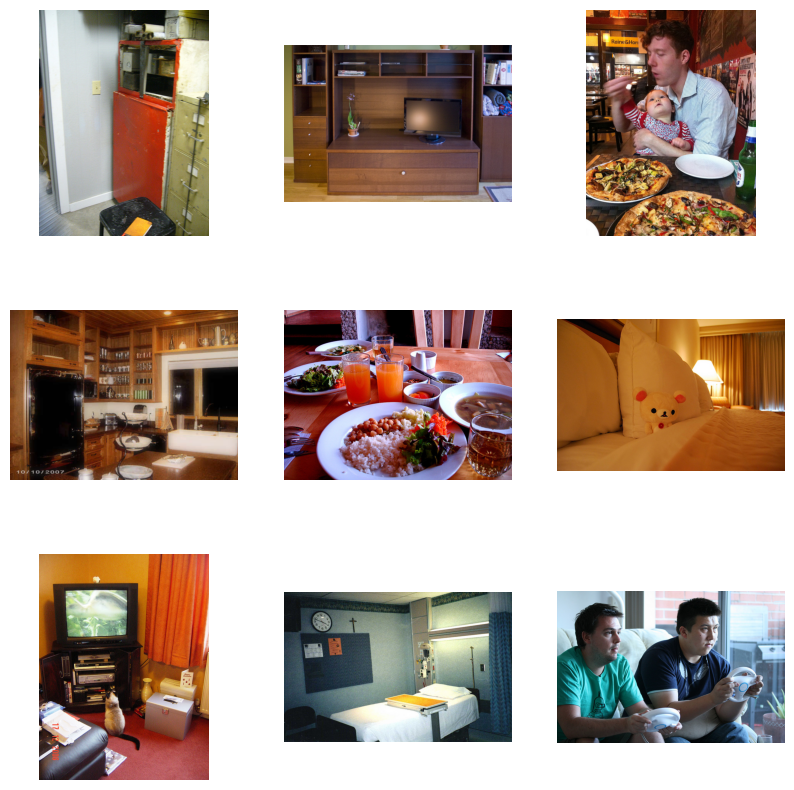

In [ ]:
_, axes = plt.subplots(3, 3, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), train_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

In [ ]:
#direct copy from https://colab.research.google.com/github/mberkay0/image-colorization/blob/main/ImageColorization.ipynb#scrollTo=xE-uUStuv1Nl
class ColorizationDataset(Dataset):
    def __init__(self, paths, split='train'):
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((256, 256),  Image.BICUBIC),
                transforms.RandomHorizontalFlip(),
            ])
        elif split == 'val':
            self.transforms = transforms.Resize((256, 256),  Image.BICUBIC)

        self.split = split
        self.size = SIZE
        self.paths = paths

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32") # Converting RGB to LAB
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 50. - 1. # grab lightness channel
        ab = img_lab[[1, 2], ...] / 110. # grab a and b channels

        return L, ab

    def __len__(self):
        return len(self.paths)

def make_dataloaders(batch_size=16, n_workers=2, pin_memory=True, **kwargs):
    dataset = ColorizationDataset(**kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=n_workers,
                            pin_memory=pin_memory)
    return dataloader

In [ ]:
train_dl = make_dataloaders(paths=train_paths, split='train')
val_dl = make_dataloaders(paths=val_paths, split='val')

In [ ]:
#inspired by work from https://github.com/richzhang/colorization/tree/master and https://github.com/williamcfrancis/CNN-Image-Colorization-Pytorch/blob/main/train.py
import torch.nn as nn
import torchvision.models as models


class Net(nn.Module):
  def __init__(self, input_size=128):
    super(Net, self).__init__()
    resnet = models.resnet34(num_classes=1000)
    resnet.conv1.weight = nn.Parameter(resnet.conv1.weight.sum(dim=1).unsqueeze(1))
    self.layers = nn.Sequential(*list(resnet.children())[0:6])

    self.upsample = nn.Sequential(
      nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.Upsample(scale_factor=2),
      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(16),
      nn.ReLU(),
      nn.Conv2d(16, 2, kernel_size=3, stride=1, padding=1), # 2 output channels, predicted a & b

      nn.Upsample(scale_factor=2)
    )

  def forward(self, input):
    features = self.layers(input)
    output = self.upsample(features)
    return output

model = Net().to(device)
print(model)

Net(
  (layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (grayscale_imgs, colorized_imgs) in enumerate(train_dl):
        grayscale_imgs = grayscale_imgs.to(device)
        colorized_imgs = colorized_imgs.to(device)
        optimizer.zero_grad()
        outputs = model(grayscale_imgs)
        loss = criterion(outputs, colorized_imgs)
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/50], Loss: 0.0136
Epoch [2/50], Loss: 0.0135
Epoch [3/50], Loss: 0.0134
Epoch [4/50], Loss: 0.0133
Epoch [5/50], Loss: 0.0133
Epoch [6/50], Loss: 0.0133
Epoch [7/50], Loss: 0.0132
Epoch [8/50], Loss: 0.0134
Epoch [9/50], Loss: 0.0131
Epoch [10/50], Loss: 0.0131
Epoch [11/50], Loss: 0.0132
Epoch [12/50], Loss: 0.0131
Epoch [13/50], Loss: 0.0131
Epoch [14/50], Loss: 0.0131
Epoch [15/50], Loss: 0.0131
Epoch [16/50], Loss: 0.0130
Epoch [17/50], Loss: 0.0130
Epoch [18/50], Loss: 0.0130
Epoch [19/50], Loss: 0.0128
Epoch [20/50], Loss: 0.0130
Epoch [21/50], Loss: 0.0130
Epoch [22/50], Loss: 0.0131
Epoch [23/50], Loss: 0.0131
Epoch [24/50], Loss: 0.0130
Epoch [25/50], Loss: 0.0127
Epoch [26/50], Loss: 0.0127
Epoch [27/50], Loss: 0.0128
Epoch [28/50], Loss: 0.0127
Epoch [29/50], Loss: 0.0126
Epoch [30/50], Loss: 0.0126
Epoch [31/50], Loss: 0.0128
Epoch [32/50], Loss: 0.0128
Epoch [33/50], Loss: 0.0126
Epoch [34/50], Loss: 0.0122
Epoch [35/50], Loss: 0.0122
Epoch [36/50], Loss: 0.0119
E

In [ ]:
def combine_and_convert(lab_l, lab_ab):
    lab_ab = lab_ab.to(lab_l.device)
    combined_lab = torch.cat((lab_l, lab_ab), dim=1)

    combined_lab = combined_lab.permute(0, 2, 3, 1)

    colorized_rgb = lab2rgb(combined_lab.cpu())
    colorized_rgb = np.clip(colorized_rgb, 0, 1)
    return colorized_rgb



In [ ]:
def calculate_psnr(img1, img2):
    mse = torch.mean((img1 - img2) ** 2)
    max_pixel = 1.0  # Assuming pixel values are normalized between [0, 1]
    psnr = 10 * torch.log10((max_pixel ** 2) / mse)
    return psnr

In [ ]:
def evaluate_model(model, dataloader, device):
    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(dataloader, 0):
            inputs, targets = batch[0].to(device), batch[1].to(device)

            outputs_ab = model(inputs)

            inputs = inputs * 100
            outputs_ab = outputs_ab * 128
            targets = targets * 128

            # Combine L channel with predicted AB channels
            colorized_rgb = combine_and_convert(inputs, outputs_ab)
            targets_rgb = combine_and_convert(inputs, targets)

            if i == 0:
                for j in range(len(inputs)):
                    visualize_example(inputs[j], colorized_rgb[j], targets_rgb[j])

            break


In [ ]:
def visualize_example(grayscale, colorized_pred, colorized_gt):

    grayscale = grayscale.squeeze().cpu().numpy()

    # Plot images
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(grayscale, cmap='gray')
    axes[0].set_title('Grayscale')
    axes[0].axis('off')
    axes[1].imshow(colorized_pred)
    axes[1].set_title('Predicted Colorized')
    axes[1].axis('off')
    axes[2].imshow(colorized_gt)
    axes[2].set_title('Ground Truth Colorized')
    axes[2].axis('off')
    plt.show()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 499131 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 483771 pixels
  return func(*args, **kwargs)


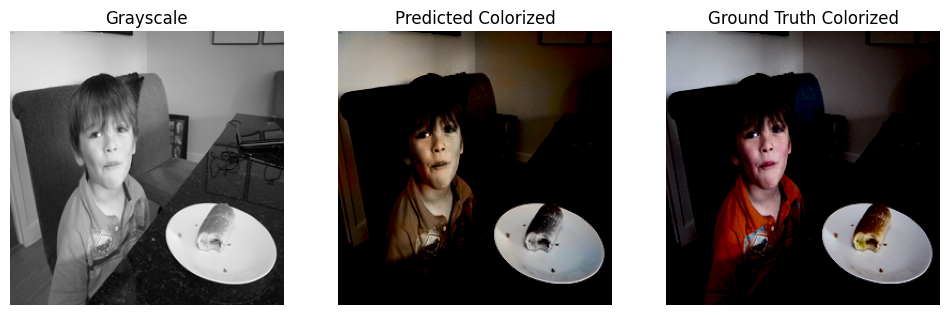

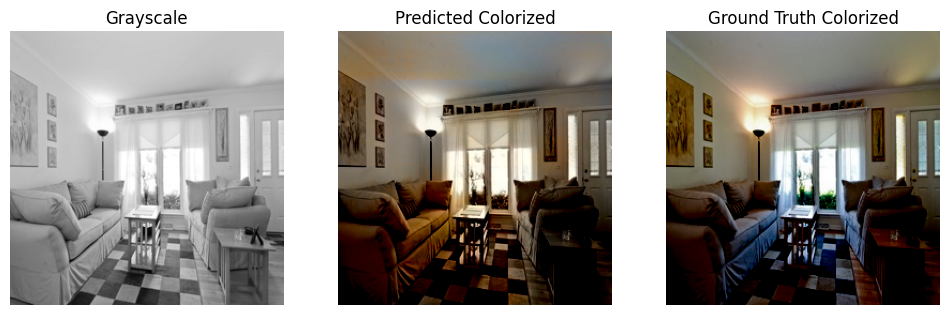

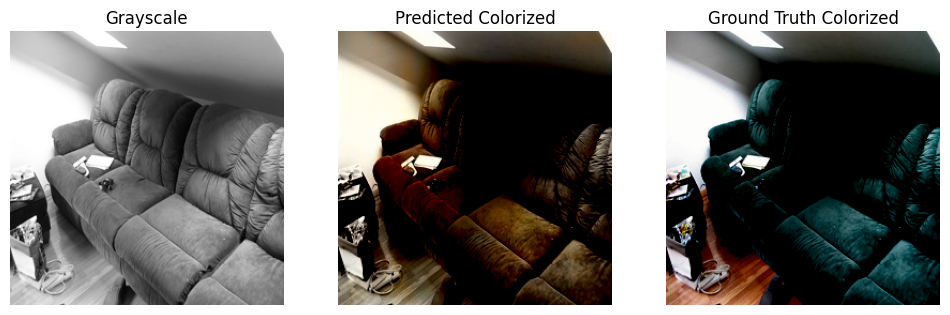

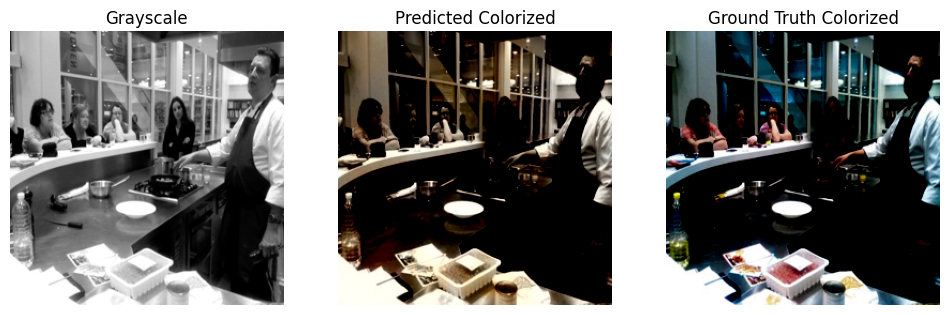

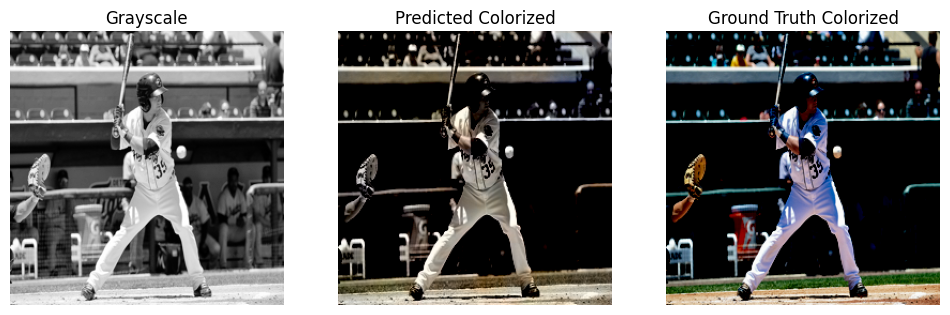

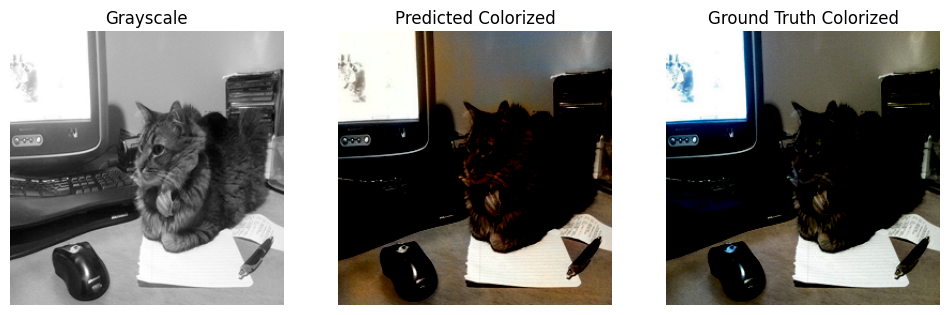

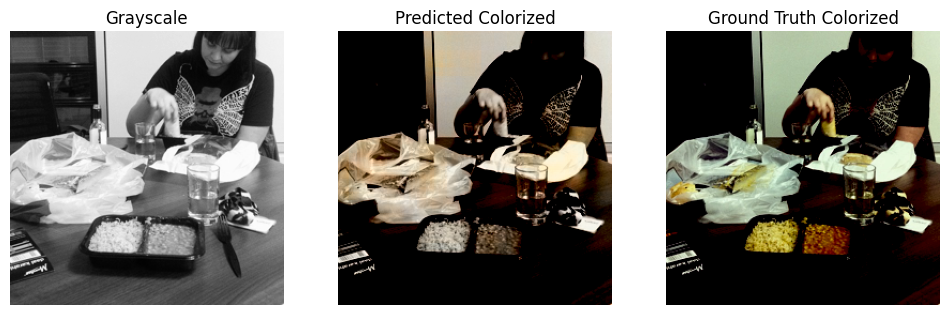

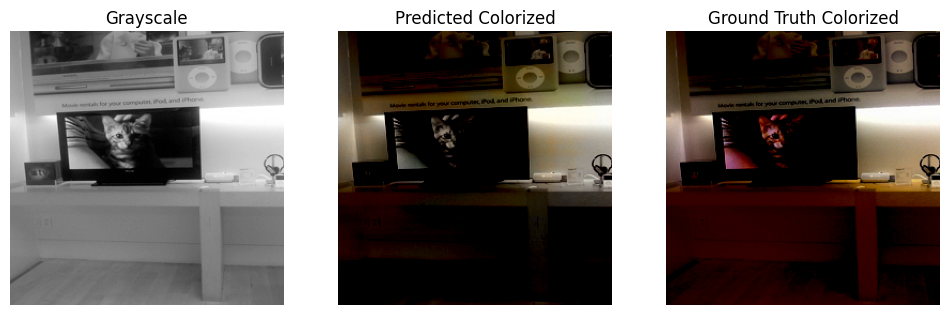

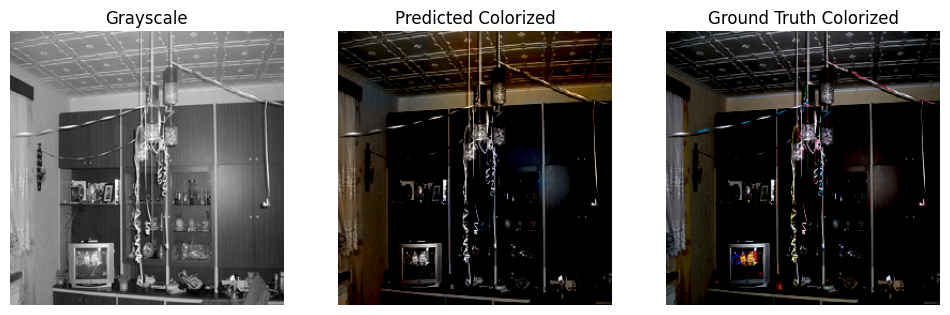

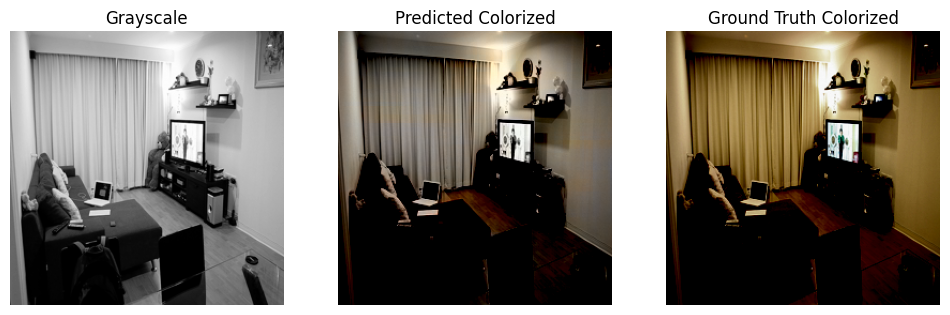

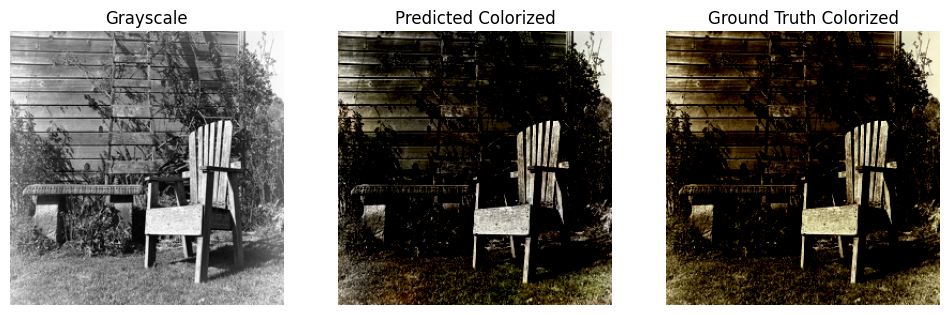

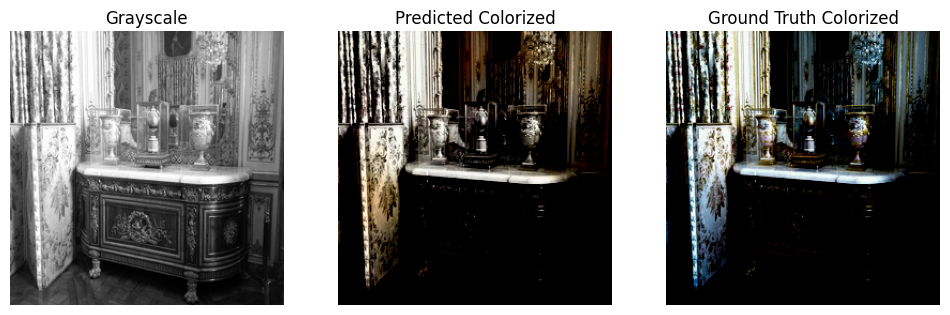

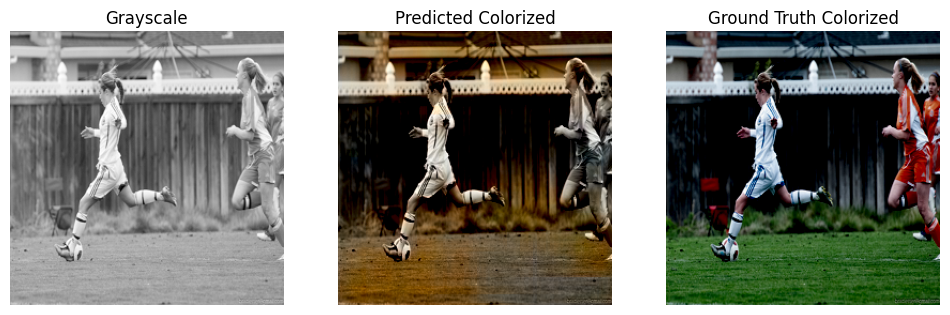

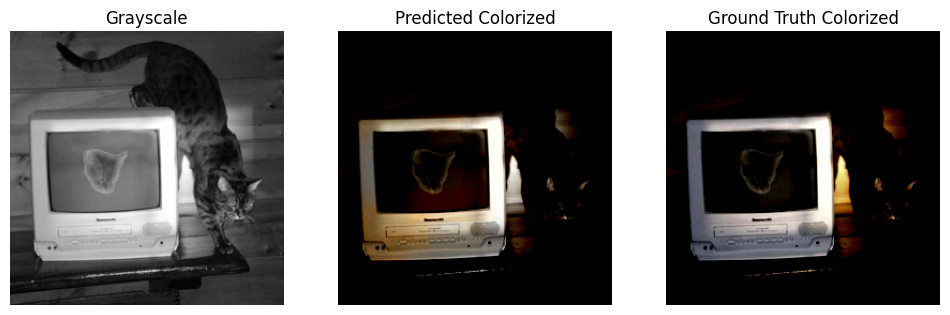

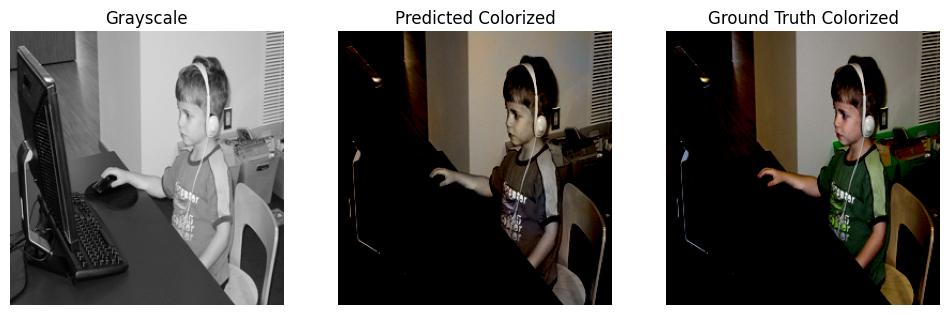

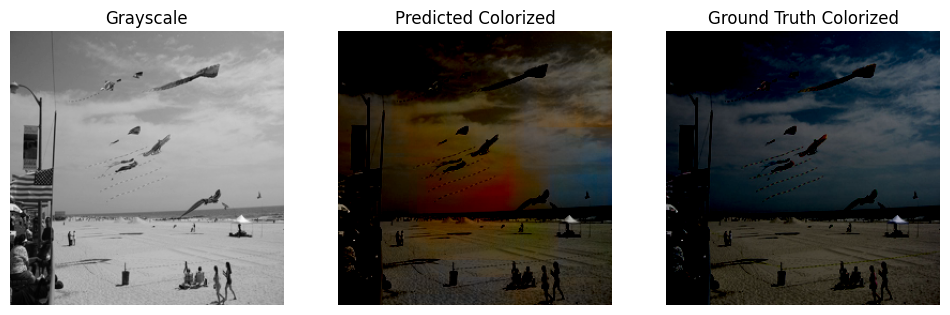

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
evaluate_model(model, val_dl, device)

In [ ]:
def evaluate_model_with_psnr(model, dataloader, device):
    model.eval()
    psnr_values = []
    with torch.no_grad():
        for i, batch in enumerate(dataloader, 0):
            inputs, targets = batch[0].to(device), batch[1].to(device)

            outputs_ab = model(inputs)

            inputs = inputs * 100
            outputs_ab = outputs_ab * 128
            targets = targets * 128

            # Combine L channel with predicted AB channels
            colorized_rgb = combine_and_convert(inputs, outputs_ab)
            targets_rgb = combine_and_convert(inputs, targets)

            # Calculate PSNR for each image in the batch
            for j in range(len(inputs)):
                psnr = calculate_psnr(torch.tensor(targets_rgb[j]), torch.tensor(colorized_rgb[j]))
                psnr_values.append(psnr.item())

    avg_psnr = torch.tensor(psnr_values).mean()
    print(f'Average PSNR: {avg_psnr.item():.2f} dB')

evaluate_model_with_psnr(model, val_dl, device)

/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 500504 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 494241 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 486683 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 477951 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 572561 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 548664 pixels
  return func(*args, **kwargs)
/usr/local/lib/python3.10/di

Average PSNR: 25.94 dB


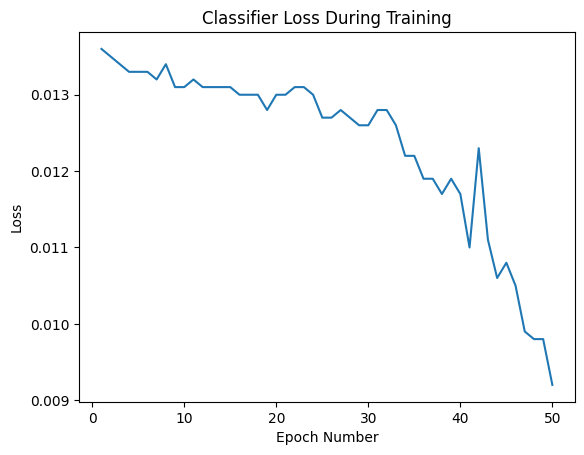

In [ ]:
losses = [0.0136, 0.0135, 0.0134, 0.0133, 0.0133, 0.0133, 0.0132, 0.0134, 0.0131, 0.0131,
0.0132, 0.0131, 0.0131, 0.0131, 0.0131, 0.0130, 0.0130, 0.0130, 0.0128, 0.0130,
0.0130, 0.0131, 0.0131, 0.0130, 0.0127, 0.0127, 0.0128, 0.0127, 0.0126, 0.0126,
0.0128, 0.0128, 0.0126, 0.0122, 0.0122, 0.0119, 0.0119, 0.0117, 0.0119, 0.0117,
0.0110, 0.0123, 0.0111, 0.0106, 0.0108, 0.0105, 0.0099, 0.0098, 0.0098, 0.0092]

epoch_count_arr = np.arange(1, 51)
plt.plot(epoch_count_arr, losses)
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.title("Classifier Loss During Training")
plt.show()